# raylab — starter (CPU + CuPy GPU)

This notebook is the starting point for a **small ray tracer** with **CPU (NumPy)** and **GPU (CuPy)** backends.

**What this notebook provides:**
- Environment checks (NumPy, CuPy, CUDA availability)
- Utility helpers (timing, image display/saving)
- A tiny **CPU "hello image"** to verify plotting pipeline
- A **CuPy smoke test** (vector add) to confirm GPU execution

We'll add the actual ray tracer kernels next.


## 1) Environment Check

In [15]:
import sys, platform, subprocess, os
print("Python:", sys.version)
print("Platform:", platform.platform())

try:
    import numpy as np
    print("NumPy:", np.__version__)
except Exception as e:
    print("NumPy import error:", e)

# Try CuPy import
cupy_info = {"available": False, "cuda_runtime_version": None, "device_count": 0}
try:
    import cupy as cp
    cupy_info["available"] = True
    try:
        # CUDA Runtime version (may be None if not available)
        cupy_info["cuda_runtime_version"] = cp.cuda.runtime.runtimeGetVersion()
    except Exception as _:
        pass

    try:
        cupy_info["device_count"] = cp.cuda.runtime.getDeviceCount()
    except Exception as _:
        pass

    print("CuPy:", cp.__version__)
    print("CUDA runtime version:", cupy_info["cuda_runtime_version"])
    print("GPU device count:", cupy_info["device_count"])
    if cupy_info["device_count"] > 0:
        for i in range(cupy_info["device_count"]):
            props = cp.cuda.runtime.getDeviceProperties(i)
            name = props["name"].decode() if isinstance(props["name"], bytes) else props["name"]
            print(f"  GPU {i}: {name}, multiProcessorCount={props.get('multiProcessorCount')}, totalGlobalMem={props.get('totalGlobalMem')}")
except Exception as e:
    print("CuPy not available:", e)


Python: 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
Platform: Linux-6.14.0-33-generic-x86_64-with-glibc2.39
NumPy: 2.3.4
CuPy: 13.6.0
CUDA runtime version: 13000
GPU device count: 1
  GPU 0: NVIDIA GeForce RTX 5060, multiProcessorCount=30, totalGlobalMem=8056799232


## 2) Utilities: timing & image helpers

In [16]:
import time
from dataclasses import dataclass
from typing import Callable, Any, Tuple
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def timeit(fn: Callable, *args, repeat: int = 1, **kwargs) -> Tuple[float, Any]:
    """Run `fn` repeatedly and return (avg_seconds, last_result)."""
    out = None
    start = time.perf_counter()
    for _ in range(repeat):
        out = fn(*args, **kwargs)
    elapsed = (time.perf_counter() - start) / repeat
    return elapsed, out

def show_image(img: np.ndarray, title: str = None):
    """Display an (H, W, 3) uint8 image."""
    assert img.ndim == 3 and img.shape[2] == 3, "Expected HxWx3 image"
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

def save_image(img: np.ndarray, path: str):
    Image.fromarray(img).save(path)
    print(f"Saved: {path}")


## 3) Hello Image (CPU) — pipeline sanity check

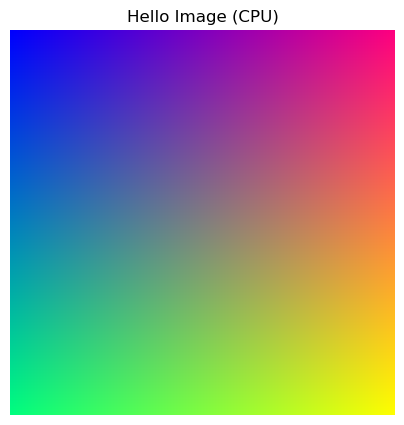

Saved: hello_cpu.png


In [17]:
import numpy as np

def hello_image_cpu(width=512, height=512) -> np.ndarray:
    """Return a simple gradient image (uint8) to verify plotting/saving."""
    x = np.linspace(0, 1, width, dtype=np.float32)
    y = np.linspace(0, 1, height, dtype=np.float32)
    xv, yv = np.meshgrid(x, y)
    r = (xv * 255).astype(np.uint8)
    g = (yv * 255).astype(np.uint8)
    b = ((1 - 0.5*(xv + yv)) * 255).astype(np.uint8)
    img = np.stack([r, g, b], axis=-1)
    return img

img = hello_image_cpu(512, 512)
show_image(img, title="Hello Image (CPU)")
save_image(img, "hello_cpu.png")


## 4) CuPy Smoke Test — verify GPU execution

In [18]:
try:
    import cupy as cp
    a = cp.arange(10**6, dtype=cp.float32)
    b = cp.arange(10**6, dtype=cp.float32)
    def add_gpu():
        return a + b
    t, out = timeit(add_gpu, repeat=10)
    print(f"CuPy vector add: avg {t*1e3:.3f} ms over 10 runs; shape={out.shape}")
    # Bring a small slice back to CPU to prove it worked
    print("Sample:", cp.asnumpy(out[:5]))
except Exception as e:
    print("CuPy test skipped/not available:", e)


CuPy vector add: avg 0.007 ms over 10 runs; shape=(1000000,)
Sample: [0. 2. 4. 6. 8.]


## 5) Next Steps (coming up)

- Implement **ray–sphere intersection** on CPU (NumPy)
- Build a minimal **ray tracer loop** (camera → rays → hit → shade)
- Port kernels to **CuPy** and measure speedup
- Extend to reflections and simple materials

We'll add these as separate cells/modules next.



## 6) CPU Ray Tracer — math & types
We'll start with basic vector ops and a simple `Ray` dataclass.


In [1]:

from dataclasses import dataclass
import numpy as np

Vec3 = np.ndarray  # alias for clarity

def v(x, y=None, z=None):
    """Create a float32 vector."""
    if y is None and z is None:
        arr = np.asarray(x, dtype=np.float32)
    else:
        arr = np.array([x, y, z], dtype=np.float32)
    return arr

def dot(a: Vec3, b: Vec3) -> float:
    return float(np.dot(a, b))

def norm(a: Vec3) -> float:
    return float(np.linalg.norm(a))

def normalize(a: Vec3) -> Vec3:
    n = norm(a)
    if n == 0: 
        return a.astype(np.float32)
    return (a / n).astype(np.float32)

@dataclass
class Ray:
    origin: Vec3
    direction: Vec3  # must be normalized



## 7) Geometry: sphere + intersection
Return the nearest hit distance `t`, hit point, normal, and material id; or `None` if no hit.


In [2]:

@dataclass
class Sphere:
    center: Vec3
    radius: float
    color: Vec3      # base albedo (0..1)
    diffuse: float   # 0..1 (Lambertian coefficient)
    specular: float  # 0..1 (mirror-like coefficient)

def intersect_sphere(ray: Ray, sph: Sphere, t_min=1e-3, t_max=1e9):
    # Ray-sphere: |o + t d - c|^2 = r^2
    oc = ray.origin - sph.center
    a = dot(ray.direction, ray.direction)
    b = 2.0 * dot(oc, ray.direction)
    c = dot(oc, oc) - sph.radius * sph.radius
    disc = b*b - 4*a*c
    if disc < 0:
        return None
    sqrt_disc = np.sqrt(disc, dtype=np.float32)
    # nearest root in range
    root = (-b - sqrt_disc) / (2*a)
    if root < t_min or root > t_max:
        root = (-b + sqrt_disc) / (2*a)
        if root < t_min or root > t_max:
            return None
    hit_pos = ray.origin + root * ray.direction
    normal = normalize(hit_pos - sph.center)
    return root, hit_pos, normal



## 8) Shading model
Simple **Lambertian** diffuse + a small **specular** term + **ambient**. Includes hard shadows (one light).


In [3]:

def reflect(v_in: Vec3, n: Vec3) -> Vec3:
    # reflect v around n (assume n normalized)
    return (v_in - 2.0 * dot(v_in, n) * n).astype(np.float32)

@dataclass
class PointLight:
    position: Vec3
    intensity: Vec3  # RGB (e.g., [1,1,1])

def trace_shadow(hit_pos: Vec3, n: Vec3, light: PointLight, spheres):
    # cast a shadow ray toward the light
    to_light = light.position - hit_pos
    dist = norm(to_light)
    dir_l = normalize(to_light)
    shadow_ray = Ray(hit_pos + 1e-3 * dir_l, dir_l)
    # if any object intersects before the light, we're in shadow
    for sph in spheres:
        res = intersect_sphere(shadow_ray, sph, t_min=1e-4, t_max=dist-1e-3)
        if res is not None:
            return True
    return False

def shade(ray: Ray, hit_pos: Vec3, n: Vec3, sph: Sphere, light: PointLight, spheres):
    ambient = 0.08
    color = ambient * sph.color.copy()

    # diffuse
    L = normalize(light.position - hit_pos)
    ndotl = max(0.0, dot(n, L))
    if ndotl > 0.0 and not trace_shadow(hit_pos, n, light, spheres):
        color += sph.diffuse * ndotl * sph.color * light.intensity

    # specular (Blinn-Phong-ish)
    if sph.specular > 0.0:
        V = normalize(-ray.direction)
        H = normalize(L + V)
        ndoth = max(0.0, dot(n, H))
        spec = (ndoth ** 32)  # shininess
        color += sph.specular * spec * light.intensity

    # clamp
    return np.clip(color, 0.0, 1.0)



## 9) Camera
Pin-hole camera with configurable FOV and look-at.


In [4]:

@dataclass
class Camera:
    origin: Vec3
    lower_left: Vec3
    horizontal: Vec3
    vertical: Vec3

def make_camera(lookfrom, lookat, vup, vfov_deg, aspect):
    theta = np.deg2rad(vfov_deg)
    h = np.tan(theta/2)
    viewport_height = 2.0 * h
    viewport_width = aspect * viewport_height

    w = normalize(lookfrom - lookat)
    u = normalize(np.cross(vup, w))
    v = np.cross(w, u).astype(np.float32)

    origin = v(lookfrom)
    horizontal = viewport_width * u
    vertical = viewport_height * v
    lower_left = origin - horizontal/2 - vertical/2 - w
    return Camera(origin, lower_left, horizontal, vertical)

def get_ray(cam: Camera, s, t):
    direction = cam.lower_left + s*cam.horizontal + t*cam.vertical - cam.origin
    return Ray(cam.origin, normalize(direction))



## 10) Render (CPU)
Primary rays + one light + hard shadows. Optionally multi-sample per pixel.


In [5]:

from tqdm import tqdm

def render_cpu(width, height, cam: Camera, spheres, light: PointLight, spp=1):
    img = np.zeros((height, width, 3), dtype=np.float32)
    for j in tqdm(range(height), desc="Rendering (CPU)"):
        for i in range(width):
            col = np.zeros(3, dtype=np.float32)
            for s in range(spp):
                # simple center-of-pixel sampling; jitter could be added later
                u = (i + 0.5) / width
                vcoord = (j + 0.5) / height
                ray = get_ray(cam, u, 1.0 - vcoord)  # flip v for image coords
                t_hit_min = 1e-3
                closest_t = 1e9
                hit = None
                hit_sph = None
                for sph in spheres:
                    res = intersect_sphere(ray, sph, t_min=t_hit_min, t_max=closest_t)
                    if res is not None:
                        t, hp, n = res
                        closest_t = t
                        hit = (hp, n)
                        hit_sph = sph
                if hit is None:
                    # sky gradient
                    unit_dir = normalize(ray.direction)
                    tbg = 0.5 * (unit_dir[1] + 1.0)
                    sky = (1.0 - tbg) * v([1.0, 1.0, 1.0]) + tbg * v([0.5, 0.7, 1.0])
                    col += sky
                else:
                    hp, n = hit
                    col += shade(ray, hp, n, hit_sph, light, spheres)
            img[j, i] = col / spp
    return (np.clip(img, 0.0, 1.0) * 255).astype(np.uint8)



## 11) Demo scene (CPU)
Two spheres + ground, one white light. Renders and saves `ray_cpu_demo.png`.


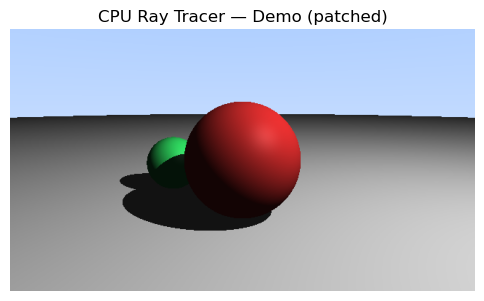

Saved: ray_cpu_demo.png


In [7]:
# --- SAFE PATCH: self-contained CPU ray tracer (no name collisions) ---
%matplotlib inline
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ---------- Math helpers ----------
Vec3 = np.ndarray

def vec(x, y=None, z=None) -> Vec3:
    if y is None and z is None:
        return np.asarray(x, dtype=np.float32)
    return np.array([x, y, z], dtype=np.float32)

def dot(a: Vec3, b: Vec3) -> float:
    return float(np.dot(a, b))

def norm(a: Vec3) -> float:
    return float(np.linalg.norm(a))

def normalize(a: Vec3) -> Vec3:
    n = norm(a)
    return (a if n == 0 else a / n).astype(np.float32)

@dataclass
class Ray:
    origin: Vec3
    direction: Vec3  # normalized

# ---------- Geometry ----------
@dataclass
class Sphere:
    center: Vec3
    radius: float
    color: Vec3
    diffuse: float
    specular: float

def intersect_sphere(ray: Ray, sph: Sphere, t_min=1e-3, t_max=1e9):
    oc = ray.origin - sph.center
    a = dot(ray.direction, ray.direction)
    b = 2.0 * dot(oc, ray.direction)
    c = dot(oc, oc) - sph.radius * sph.radius
    disc = b*b - 4*a*c
    if disc < 0: 
        return None
    sqrt_disc = np.sqrt(disc, dtype=np.float32)
    root = (-b - sqrt_disc) / (2*a)
    if root < t_min or root > t_max:
        root = (-b + sqrt_disc) / (2*a)
        if root < t_min or root > t_max:
            return None
    hit_pos = ray.origin + root * ray.direction
    normal = normalize(hit_pos - sph.center)
    return root, hit_pos, normal

# ---------- Shading ----------
def reflect(v_in: Vec3, n: Vec3) -> Vec3:
    return (v_in - 2.0 * dot(v_in, n) * n).astype(np.float32)

@dataclass
class PointLight:
    position: Vec3
    intensity: Vec3

def trace_shadow(hit_pos: Vec3, n: Vec3, light: PointLight, spheres):
    to_light = light.position - hit_pos
    dist = norm(to_light)
    dir_l = normalize(to_light)
    shadow_ray = Ray(hit_pos + 1e-3 * dir_l, dir_l)
    for sph in spheres:
        res = intersect_sphere(shadow_ray, sph, t_min=1e-4, t_max=dist-1e-3)
        if res is not None:
            return True
    return False

def shade(ray: Ray, hit_pos: Vec3, n: Vec3, sph: Sphere, light: PointLight, spheres):
    ambient = 0.08
    color = ambient * sph.color.copy()
    L = normalize(light.position - hit_pos)
    ndotl = max(0.0, dot(n, L))
    if ndotl > 0.0 and not trace_shadow(hit_pos, n, light, spheres):
        color += sph.diffuse * ndotl * sph.color * light.intensity
    if sph.specular > 0.0:
        V = normalize(-ray.direction)
        H = normalize(L + V)
        ndoth = max(0.0, dot(n, H))
        spec = (ndoth ** 32)
        color += sph.specular * spec * light.intensity
    return np.clip(color, 0.0, 1.0)

# ---------- Camera (no 'v' shadowing) ----------
@dataclass
class Camera:
    origin: Vec3
    lower_left: Vec3
    horizontal: Vec3
    vertical: Vec3

def make_camera(lookfrom, lookat, vup, vfov_deg, aspect):
    theta = np.deg2rad(vfov_deg)
    h = np.tan(theta/2)
    viewport_height = 2.0 * h
    viewport_width = aspect * viewport_height

    w_cam = normalize(vec(lookfrom) - vec(lookat))
    u_cam = normalize(np.cross(vec(vup), w_cam))
    v_cam = np.cross(w_cam, u_cam).astype(np.float32)

    origin = vec(lookfrom)
    horizontal = viewport_width * u_cam
    vertical = viewport_height * v_cam
    lower_left = origin - horizontal/2 - vertical/2 - w_cam
    return Camera(origin, lower_left, horizontal, vertical)

def get_ray(cam: Camera, s, t):
    direction = cam.lower_left + s*cam.horizontal + t*cam.vertical - cam.origin
    return Ray(cam.origin, normalize(direction))

# ---------- Render ----------
def render_cpu(width, height, cam: Camera, spheres, light: PointLight, spp=1):
    img = np.zeros((height, width, 3), dtype=np.float32)
    for j in range(height):
        for i in range(width):
            col = np.zeros(3, dtype=np.float32)
            for _ in range(spp):
                u = (i + 0.5) / width
                vcoord = (j + 0.5) / height
                ray = get_ray(cam, u, 1.0 - vcoord)  # flip v for image coords
                closest_t = 1e9
                hit = None
                hit_sph = None
                for sph in spheres:
                    res = intersect_sphere(ray, sph, t_min=1e-3, t_max=closest_t)
                    if res is not None:
                        t, hp, nrm = res
                        closest_t = t
                        hit = (hp, nrm)
                        hit_sph = sph
                if hit is None:
                    unit_dir = normalize(ray.direction)
                    tbg = 0.5 * (unit_dir[1] + 1.0)
                    sky = (1.0 - tbg) * vec([1.0, 1.0, 1.0]) + tbg * vec([0.5, 0.7, 1.0])
                    col += sky
                else:
                    hp, nrm = hit
                    col += shade(ray, hp, nrm, hit_sph, light, spheres)
            img[j, i] = col / spp
    return (np.clip(img, 0.0, 1.0) * 255).astype(np.uint8)

def show_image(img: np.ndarray, title: str = None):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

def save_image(img: np.ndarray, path: str):
    Image.fromarray(img).save(path)
    print(f"Saved: {path}")

# ---------- Demo scene ----------
spheres = [
    Sphere(center=vec(0.0, 0.0, -1.2),   radius=0.5,  color=vec(0.95, 0.2, 0.2), diffuse=0.9, specular=0.1),
    Sphere(center=vec(-0.8, -0.2, -2.0), radius=0.3,  color=vec(0.2, 0.9, 0.4),  diffuse=0.9, specular=0.05),
    Sphere(center=vec(0.0, -1000.5, -1.0), radius=1000.0, color=vec(0.9, 0.9, 0.9), diffuse=0.9, specular=0.0),
]
light = PointLight(position=vec(2.5, 3.0, 0.5), intensity=vec(1.0, 1.0, 1.0))

aspect = 16/9
width = 640
height = int(width / aspect)
cam = make_camera(lookfrom=vec(0.0, 0.5, 1.2), lookat=vec(0.0, 0.0, -1.2), vup=vec(0,1,0), vfov_deg=50, aspect=aspect)

img_cpu = render_cpu(width, height, cam, spheres, light, spp=1)
show_image(img_cpu, title="CPU Ray Tracer — Demo (patched)")
save_image(img_cpu, "ray_cpu_demo.png")


In [8]:

import numpy as np
from dataclasses import dataclass

# Extend Sphere with reflectivity (0..1)
@dataclass
class Sphere:
    center: Vec3
    radius: float
    color: Vec3
    diffuse: float
    specular: float
    reflectivity: float = 0.0  # new

def trace_closest_hit(ray: Ray, spheres, t_min=1e-3, t_max=1e9):
    closest_t = t_max
    hit = None
    hit_sph = None
    for sph in spheres:
        res = intersect_sphere(ray, sph, t_min=t_min, t_max=closest_t)
        if res is not None:
            t, hp, nrm = res
            closest_t = t
            hit = (hp, nrm)
            hit_sph = sph
    return (hit_sph, *hit) if hit is not None else (None, None, None)

def sky_color(dir_vec: Vec3) -> Vec3:
    unit_dir = normalize(dir_vec)
    tbg = 0.5 * (unit_dir[1] + 1.0)
    return (1.0 - tbg) * vec([1.0, 1.0, 1.0]) + tbg * vec([0.5, 0.7, 1.0])

def trace_color(ray: Ray, spheres, light: PointLight, depth: int, max_depth: int) -> Vec3:
    if depth > max_depth:
        return sky_color(ray.direction)
    sph, hp, nrm = trace_closest_hit(ray, spheres)
    if sph is None:
        return sky_color(ray.direction)

    # Local shading (ambient + lambert + specular, with hard shadow)
    local = shade(ray, hp, nrm, sph, light, spheres)

    # Reflection
    r = float(sph.reflectivity)
    if r > 0.0 and depth < max_depth:
        refl_dir = reflect(ray.direction, nrm)
        refl_ray = Ray(hp + 1e-3 * refl_dir, refl_dir)
        refl_col = trace_color(refl_ray, spheres, light, depth+1, max_depth)
        return (1.0 - r) * local + r * refl_col
    else:
        return local

def render_cpu_aa(width, height, cam: Camera, spheres, light: PointLight, spp=8, max_depth=2, seed=42):
    rng = np.random.default_rng(seed)
    img = np.zeros((height, width, 3), dtype=np.float32)
    for j in range(height):
        for i in range(width):
            col = np.zeros(3, dtype=np.float32)
            for _ in range(spp):
                u = (i + rng.random()) / width
                vcoord = (j + rng.random()) / height
                ray = get_ray(cam, u, 1.0 - vcoord)
                col += trace_color(ray, spheres, light, depth=0, max_depth=max_depth)
            img[j, i] = col / spp
    return (np.clip(img, 0.0, 1.0) * 255).astype(np.uint8)


Render time (CPU, 800x450, spp=16, max_depth=3): 163.18s


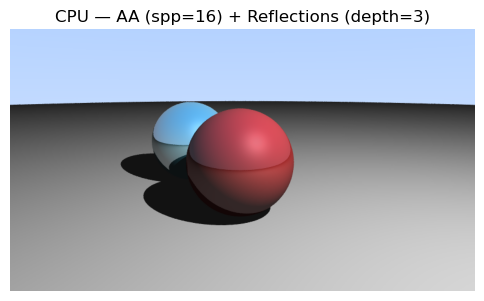

Saved: ray_cpu_aa_reflect.png


In [9]:

import time

# New scene with some reflectivity
spheres_reflect = [
    Sphere(center=vec(0.0, 0.0, -1.2),   radius=0.5,  color=vec(0.95, 0.2, 0.2), diffuse=0.9, specular=0.2, reflectivity=0.2),
    Sphere(center=vec(-0.9, 0.0, -2.2),  radius=0.5,  color=vec(0.2, 0.8, 0.95), diffuse=0.9, specular=0.4, reflectivity=0.6),
    Sphere(center=vec(0.0, -1000.5, -1.0), radius=1000.0, color=vec(0.9, 0.9, 0.9), diffuse=0.9, specular=0.0, reflectivity=0.0),
]
light2 = PointLight(position=vec(2.5, 3.0, 0.5), intensity=vec(1.0, 1.0, 1.0))

aspect = 16/9
width = 800
height = int(width / aspect)
cam2 = make_camera(lookfrom=vec(0.7, 0.7, 1.6), lookat=vec(0.0, 0.0, -1.3), vup=vec(0,1,0), vfov_deg=45, aspect=aspect)

t0 = time.perf_counter()
img_cpu_aa = render_cpu_aa(width, height, cam2, spheres_reflect, light2, spp=16, max_depth=3, seed=123)
t1 = time.perf_counter()
print(f"Render time (CPU, {width}x{height}, spp=16, max_depth=3): {(t1-t0):.2f}s")

show_image(img_cpu_aa, title="CPU — AA (spp=16) + Reflections (depth=3)")
save_image(img_cpu_aa, "ray_cpu_aa_reflect.png")


14) GPU Renderer with CuPy (vectorized)
We port the hot path to CuPy. Strategy:

Process all pixels in parallel on the GPU.
Loop over samples per pixel and max depth in Python (small loops), but keep math on GPU.
Support: diffuse + specular + reflections + hard shadows + sky.

In [20]:

import cupy as cp
import numpy as np
import time

# ---------- CuPy vector helpers ----------
def cp_vec(x, y=None, z=None):
    if y is None and z is None:
        return cp.asarray(x, dtype=cp.float32)
    return cp.array([x, y, z], dtype=cp.float32)

def cp_dot(a, b):
    return cp.sum(a * b, axis=-1)

def cp_norm(a):
    return cp.sqrt(cp_dot(a, a) + 1e-20)

def cp_normalize(a):
    return a / cp_norm(a)[..., None]

# ---------- Pack spheres into device arrays ----------
def pack_spheres_to_device(spheres):
    centers = cp.asarray([s.center for s in spheres], dtype=cp.float32)
    radii   = cp.asarray([s.radius for s in spheres], dtype=cp.float32)
    colors  = cp.asarray([s.color  for s in spheres], dtype=cp.float32)
    diffuse = cp.asarray([s.diffuse for s in spheres], dtype=cp.float32)
    specular= cp.asarray([s.specular for s in spheres], dtype=cp.float32)
    refl    = cp.asarray([getattr(s, "reflectivity", 0.0) for s in spheres], dtype=cp.float32)
    return centers, radii, colors, diffuse, specular, refl

# ---------- Intersections (all pixels vs all spheres) ----------
def cp_intersect_spheres(ray_o, ray_d, centers, radii, t_min=1e-3, t_max=1e9):
    # ray_o: (P,3), ray_d: (P,3)
    # centers: (N,3), radii: (N,)
    oc = ray_o[:, None, :] - centers[None, :, :]               # (P,N,3)
    a = cp_dot(ray_d, ray_d)[:, None]                           # (P,1)
    b = 2.0 * cp.sum(oc * ray_d[:, None, :], axis=-1)           # (P,N)
    c = cp_dot(oc, oc) - radii[None, :]**2                      # (P,N)
    disc = b*b - 4*a*c                                          # (P,N)

    valid = disc > 0
    sqrt_disc = cp.zeros_like(disc)
    sqrt_disc[valid] = cp.sqrt(disc[valid])
    t1 = (-b - sqrt_disc) / (2*a)                               # (P,N)
    t2 = (-b + sqrt_disc) / (2*a)

    # Choose nearest valid root in range
    t = cp.where((t1 >= t_min) & (t1 <= t_max), t1, cp.inf)
    t = cp.where((t2 >= t_min) & (t2 <= t)   , t2, t)

    # Argmin across spheres
    t_hit = cp.min(t, axis=1)                                   # (P,)
    hit_idx = cp.argmin(t, axis=1)                               # (P,)
    hit_mask = cp.isfinite(t_hit)

    # Compute hit pos/normal where hit exists
    hit_pos = cp.zeros_like(ray_o)
    normal  = cp.zeros_like(ray_o)
    if cp.any(hit_mask):
        hp = ray_o[hit_mask] + t_hit[hit_mask, None] * ray_d[hit_mask]
        nrm = cp_normalize(hp - centers[hit_idx[hit_mask]])
        hit_pos[hit_mask] = hp
        normal[hit_mask] = nrm
    return hit_mask, t_hit, hit_idx, hit_pos, normal

# ---------- Shading (CuPy) ----------
def cp_reflect(v_in, n):
    return v_in - 2.0 * cp_dot(v_in, n)[..., None] * n

def cp_sky(dir_vec):
    unit = cp_normalize(dir_vec)
    tbg = 0.5 * (unit[...,1] + 1.0)
    white = cp_vec(1.0,1.0,1.0)
    blue  = cp_vec(0.5,0.7,1.0)
    return (1.0 - tbg)[...,None]*white + tbg[...,None]*blue

def cp_trace_shadow(hit_pos, light_pos, centers, radii):
    to_light = light_pos[None,:] - hit_pos                # (P,3)
    dist = cp_norm(to_light)                              # (P,)
    dir_l = cp_normalize(to_light)
    shadow_o = hit_pos + 1e-3 * dir_l
    hit_mask, t_hit, _, _, _ = cp_intersect_spheres(shadow_o, dir_l, centers, radii, t_min=1e-4)
    blocked = hit_mask & (t_hit < dist - 1e-3)
    return blocked

# --- PATCH: safer masked updates to avoid shape mismatches ---
import cupy as cp
import time

def render_cupy(width, height, cam: Camera, spheres, light: PointLight, spp=8, max_depth=3, seed=42):
    origin = cp.asarray(cam.origin, dtype=cp.float32)
    lower_left = cp.asarray(cam.lower_left, dtype=cp.float32)
    horizontal = cp.asarray(cam.horizontal, dtype=cp.float32)
    vertical = cp.asarray(cam.vertical, dtype=cp.float32)

    centers, radii, colors, diffuse, specular, refl = pack_spheres_to_device(spheres)
    light_pos = cp.asarray(light.position, dtype=cp.float32)
    light_int = cp.asarray(light.intensity, dtype=cp.float32)

    rng = cp.random.RandomState(seed)

    acc = cp.zeros((height, width, 3), dtype=cp.float32)
    P = width * height

    for _ in range(spp):
        # jittered sample coords (RandomState -> use rand, not random)
        ju = rng.rand(height, width, dtype=cp.float32)
        jv = rng.rand(height, width, dtype=cp.float32)
        u = (cp.arange(width)[None, :] + ju) / width
        v = (cp.arange(height)[:, None] + jv) / height
        v = 1.0 - v

        # primary rays
        dirr = lower_left[None,None,:] + u[...,None]*horizontal[None,None,:] + v[...,None]*vertical[None,None,:] - origin[None,None,:]
        dirr = cp_normalize(dirr.reshape(P, 3))
        ro   = cp.broadcast_to(origin, (P, 3)).copy()

        throughput = cp.ones((P, 3), dtype=cp.float32)
        pixel_col  = cp.zeros((P, 3), dtype=cp.float32)

        for _depth in range(max_depth + 1):
            hit_mask, t_hit, hit_idx, hp, nrm = cp_intersect_spheres(ro, dirr, centers, radii)

            # misses → add sky and zero-out throughput so they stop contributing
            miss_mask = ~hit_mask
            if cp.any(miss_mask):
                pixel_col[miss_mask] += throughput[miss_mask] * cp_sky(dirr[miss_mask])
                throughput[miss_mask] = 0.0  # stop further bounces for misses

            if cp.any(hit_mask):
                idx = hit_idx[hit_mask]

                # local shading
                L = cp_normalize(light_pos[None, :] - hp[hit_mask])
                ndotl = cp.maximum(0.0, cp_dot(nrm[hit_mask], L))
                blocked = cp_trace_shadow(hp[hit_mask], light_pos, centers, radii)
                vis = (~blocked).astype(cp.float32)

                base = colors[idx]
                kd = diffuse[idx][:, None]
                ks = specular[idx][:, None]

                local = 0.08*base + (kd * ndotl[:, None] * base * light_int * vis[:, None])

                V = cp_normalize(-dirr[hit_mask])
                H = cp_normalize(L + V)
                ndoth = cp.maximum(0.0, cp_dot(nrm[hit_mask], H))
                local += (ndoth**32)[:, None] * ks * light_int
                local = cp.clip(local, 0.0, 1.0)

                r = refl[idx][:, None]

                # accumulate local term
                pixel_col[hit_mask] += throughput[hit_mask] * (1.0 - r) * local

                # prepare reflection rays — assign by mask to keep shapes consistent
                refl_dir = cp_reflect(dirr[hit_mask], nrm[hit_mask])
                # update origins and directions only for hits
                ro_h = hp[hit_mask] + 1e-3 * refl_dir
                dir_h = cp_normalize(refl_dir)

                # masked writes
                ro = ro.copy()
                ro[hit_mask] = ro_h
                dirr = dirr.copy()
                dirr[hit_mask] = dir_h

                # update throughput on hits
                throughput_h = throughput[hit_mask] * r
                throughput[hit_mask] = throughput_h

            # early-out if nothing meaningful remains
            if float(cp.max(throughput)) < 1e-4:
                # add residual sky for anyone still 'alive' (very small contrib)
                alive = cp.any(throughput > 0, axis=1)
                if cp.any(alive):
                    pixel_col[alive] += throughput[alive] * cp_sky(dirr[alive])
                break

        acc += pixel_col.reshape(height, width, 3)

    img = (cp.clip(acc / spp, 0.0, 1.0) * 255).astype(cp.uint8)
    return cp.asnumpy(img)



Render time (GPU/CuPy, 800x450, spp=16, max_depth=3): 3.89s


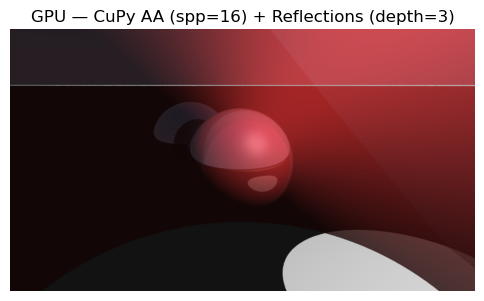

Saved: ray_gpu_aa_reflect.png


In [21]:

# Use the same 'spheres_reflect', 'light2', and 'cam2' from Section 13
# If you restarted the kernel, re-run the earlier cells to define them.

width = 800
height = int(width / (16/9))

t0 = time.perf_counter()
img_gpu = render_cupy(width, height, cam2, spheres_reflect, light2, spp=16, max_depth=3, seed=123)
t1 = time.perf_counter()
print(f"Render time (GPU/CuPy, {width}x{height}, spp=16, max_depth=3): {(t1-t0):.2f}s")

show_image(img_gpu, title="GPU — CuPy AA (spp=16) + Reflections (depth=3)")
save_image(img_gpu, "ray_gpu_aa_reflect.png")


16) Double‑Slit with Wave Optics (GPU, CuPy) — Fresnel Diffraction
Ray tracing is great for geometric optics, but the double‑slit is a wave phenomenon. We’ll simulate it using scalar diffraction on the GPU (CuPy) via the Fresnel (paraxial) approximation.

Method (Angular Spectrum / Fresnel):

Define an aperture field ( U_0(x,y) ) at ( z=0 ) (two slits).
Propagate a distance ( z ) with transfer function [ U_z = \mathcal{F}^{-1}{ \mathcal{F}{U_0} \cdot H(f_x,f_y) },\quad H = e^{i k z} e^{-i\pi \lambda z (f_x^2+f_y^2)} ]
Intensity = ( |U_z|^2 ).
This gives both near‑field (Fresnel) and far‑field (Fraunhofer) patterns depending on ( z ).

In [26]:

import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

def ds_create_aperture(Nx=1024, Ny=768, dx=5e-6, slit_width=20e-6, slit_sep=120e-6, slit_height=None):
    """Return (x, y, aperture) on GPU for a vertical double-slit.
    Nx,Ny: grid size, dx: pixel pitch (assumed square), slit_width/sep/height in meters.
    """
    if slit_height is None:
        slit_height = Ny * dx  # full height by default
    x = (cp.arange(Nx, dtype=cp.float32) - Nx/2) * dx
    y = (cp.arange(Ny, dtype=cp.float32) - Ny/2) * dx
    X, Y = cp.meshgrid(x, y)  # (Ny,Nx)

    # Two vertical rectangular slits centered at +/- slit_sep/2 along x
    def rect(u):  # 1 if |u|<=0.5 else 0
        return (cp.abs(u) <= 0.5).astype(cp.float32)

    slit1 = rect((X + slit_sep/2) / slit_width) * rect(Y / slit_height)
    slit2 = rect((X - slit_sep/2) / slit_width) * rect(Y / slit_height)
    aperture = slit1 + slit2
    return x, y, aperture  # GPU arrays

def fresnel_propagate(U0, dx, wavelength, z):
    """Fresnel propagation using quadratic phase in frequency domain (CuPy).
    U0: field at z=0 (Ny,Nx), dx: sample pitch (m), wavelength (m), z: distance (m)
    Returns Uz on the same grid.
    """
    Ny, Nx = U0.shape
    fx = cp.fft.fftfreq(Nx, d=dx).astype(cp.float32)
    fy = cp.fft.fftfreq(Ny, d=dx).astype(cp.float32)
    FX, FY = cp.meshgrid(fx, fy)  # (Ny,Nx)

    k = 2*cp.pi / wavelength
    H = cp.exp(1j * k * z) * cp.exp(-1j * cp.pi * wavelength * z * (FX**2 + FY**2))
    Uz = cp.fft.ifft2(cp.fft.fft2(U0) * H)
    return Uz

def ds_simulate(Nx=1024, Ny=768, dx=5e-6, wavelength=532e-9, z=0.5,  # meters
                slit_width=20e-6, slit_sep=120e-6, slit_height=None):
    # Aperture (amplitude 1 inside slits, 0 elsewhere)
    x, y, aperture = ds_create_aperture(Nx, Ny, dx, slit_width, slit_sep, slit_height)
    U0 = aperture.astype(cp.complex64)  # plane wave amplitude inside slits
    Uz = fresnel_propagate(U0, dx, wavelength, z)
    I = cp.abs(Uz)**2
    # Normalize for display
    I_disp = (I / I.max()).astype(cp.float32)
    return x, y, I_disp, aperture, Uz

def ds_plot_result(x, y, I_disp, aperture, title="Double‑Slit Fresnel (GPU)"):
    I_cpu = cp.asnumpy(I_disp)
    A_cpu = cp.asnumpy(aperture)
    extent = [float(x.min()), float(x.max()), float(y.min()), float(y.max())]

    plt.figure(figsize=(7,5))
    plt.imshow(I_cpu, origin="lower", extent=extent, aspect="auto")
    plt.title(title)
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.colorbar(label="Normalized Intensity")
    plt.show()

    # 1D centerline cut (y=0)
    mid = I_cpu.shape[0]//2
    plt.figure(figsize=(7,3))
    plt.plot(cp.asnumpy(x), I_cpu[mid], label="centerline intensity")
    plt.xlabel("x (m)")
    plt.ylabel("I/Imax")
    plt.title("Centerline slice (y≈0)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


17) Double‑Slit Demo (GPU)
Play with wavelength λ, slit width a, separation d, distance z, and pixel pitch dx.

Smaller dx resolves finer fringes (more pixels, heavier compute).
Larger z approaches Fraunhofer (far-field) pattern.

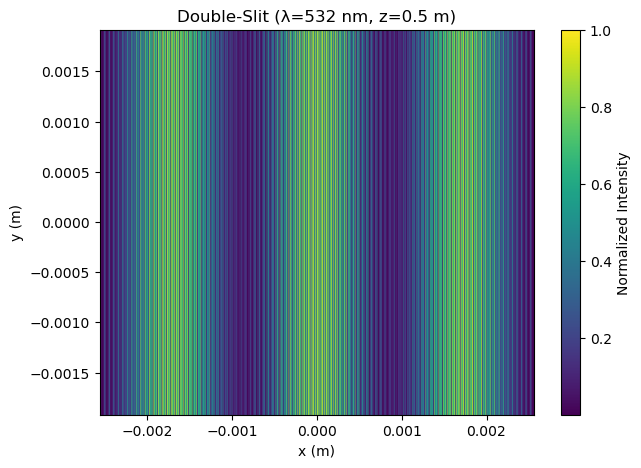

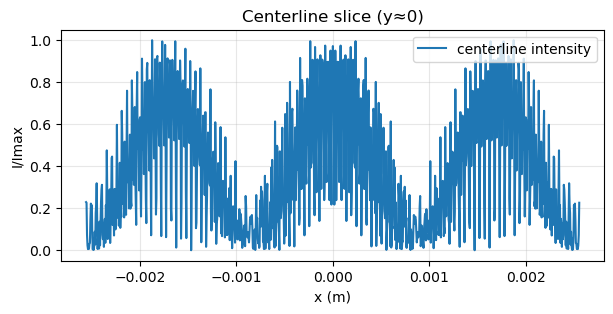

In [27]:

# Parameters (meters)
wavelength = 532e-9    # 532 nm (green)
dx = 5e-6              # pixel pitch 5 µm
Nx, Ny = 1024, 768
slit_width = 25e-6     # 25 µm
slit_sep   = 150e-6    # 150 µm
z = 0.5                # 0.5 m to screen

x, y, I_disp, aperture, Uz = ds_simulate(Nx=Nx, Ny=Ny, dx=dx, wavelength=wavelength,
                                         z=z, slit_width=slit_width, slit_sep=slit_sep)
ds_plot_result(x, y, I_disp, aperture, title=f"Double‑Slit (λ={wavelength*1e9:.0f} nm, z={z} m)")


18) Analytic Fraunhofer Check (1D)
For narrow slits and large ( z ), the centerline intensity approximates: [ I(\theta) \propto \cos^2!\left(\tfrac{\pi d}{\lambda}\sin\theta\right) \cdot \left( \tfrac{\sin(\pi a \sin\theta / \lambda)}{\pi a \sin\theta / \lambda} \right)^2. ]

We compare the simulated centerline to this analytic envelope.

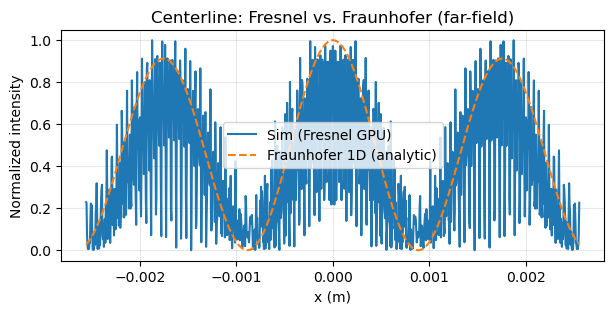

In [28]:

import numpy as np
# Extract centerline (y ≈ 0) from the GPU result:
I_cpu = cp.asnumpy(I_disp)
x_cpu = cp.asnumpy(x)
mid = I_cpu.shape[0]//2
I_line = I_cpu[mid]

# Fraunhofer model on the same x-axis (small angle: sinθ ≈ x / z)
lam = wavelength
a = slit_width
d = slit_sep
theta = x_cpu / z
beta = np.pi * a * np.sin(theta) / lam
alpha = np.pi * d * np.sin(theta) / lam
# handle beta=0 safely
sinc = np.ones_like(beta)
nz = beta != 0
sinc[nz] = np.sin(beta[nz]) / beta[nz]
I_far = (np.cos(alpha)**2) * (sinc**2)
I_far /= I_far.max()

plt.figure(figsize=(7,3))
plt.plot(x_cpu, I_line, label="Sim (Fresnel GPU)")
plt.plot(x_cpu, I_far, linestyle="--", label="Fraunhofer 1D (analytic)")
plt.xlabel("x (m)")
plt.ylabel("Normalized intensity")
plt.title("Centerline: Fresnel vs. Fraunhofer (far-field)");
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
